In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
train_df = pd.read_csv("mnist_train.csv")
test_df = pd.read_csv("mnist_test.csv")
train_df.head()


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train = train_df.iloc[:,1:].values.reshape(-1, 28, 28, 1).astype("float")/255.0
y_train_raw = train_df.iloc[:, 0].values
y_train = to_categorical(train_df.iloc[:, 0].values, num_classes=10)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
X_test = test_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype("float32") / 255.0
y_test_raw = test_df.iloc[:, 0].values
y_test = to_categorical(y_test_raw, num_classes=10)

In [ ]:
inputs = Input(shape=(28,28,1))
inputs

<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_7>

In [ ]:
# Build and Train
x = Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu', name="Conv2D_1")(inputs)

x = MaxPooling2D(pool_size=(2, 2), strides=2, name="MaxPool_1")(x)

x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', name="Conv2D_2")(x)

x = MaxPooling2D(pool_size=(2, 2), strides=2, name="MaxPool_2")(x)

x = Flatten(name="Flatten")(x)

outputs = Dense(10, activation='softmax', name="Output")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test), verbose=2)


Epoch 1/3
1875/1875 - 31s - 16ms/step - accuracy: 0.9308 - loss: 0.2340 - val_accuracy: 0.9711 - val_loss: 0.0893
Epoch 2/3
1875/1875 - 44s - 23ms/step - accuracy: 0.9729 - loss: 0.0888 - val_accuracy: 0.9778 - val_loss: 0.0637
Epoch 3/3
1875/1875 - 29s - 16ms/step - accuracy: 0.9785 - loss: 0.0680 - val_accuracy: 0.9820 - val_loss: 0.0511


In [ ]:
train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1]
test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]


print(f"Training Accuracy after 3 epochs: {train_accuracy}")
print(f"Test Accuracy after 3 epochs: {test_accuracy}")


Training Accuracy after 3 epochs: 0.9837499856948853
Test Accuracy after 3 epochs: 0.9819999933242798


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


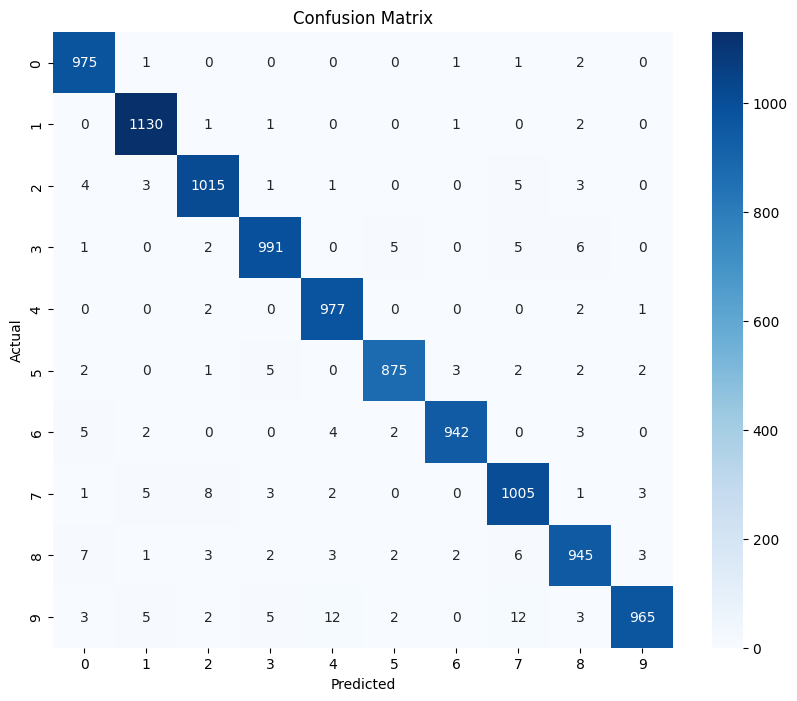

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_raw, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
flatten_model = Model(inputs=model.input, outputs=model.get_layer('Flatten').output)
X_train_feat = flatten_model.predict(X_train)
X_test_feat = flatten_model.predict(X_test)
feature_vector_size = X_train_feat.shape[1]
print(f"Q2: Final Feature Vector Size: {feature_vector_size}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Q2: Final Feature Vector Size: 784


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_feat, y_train_raw)
knn_pred = knn.predict(X_test_feat)
knn_acc = accuracy_score(y_test_raw, knn_pred)
print(f"Q4: kNN Accuracy on Flattened Features: {knn_acc}")

Q4: kNN Accuracy on Flattened Features: 0.9791


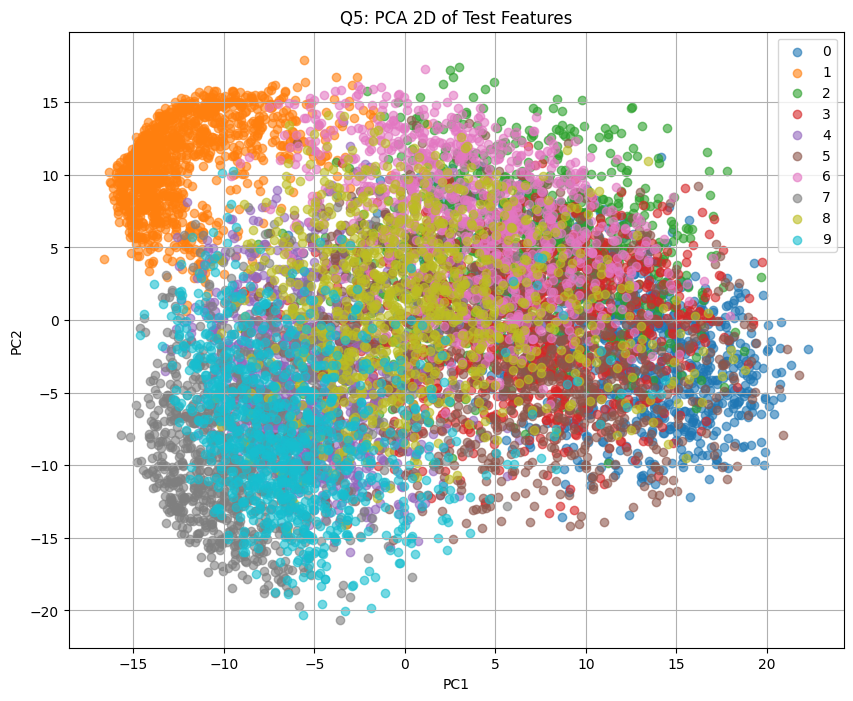

In [ ]:
pca_2d = PCA(n_components=2)
X_test_pca_2d = pca_2d.fit_transform(X_test_feat)

plt.figure(figsize=(10, 8))
for digit in range(10):
    idxs = np.where(y_test_raw == digit)
    plt.scatter(X_test_pca_2d[idxs, 0], X_test_pca_2d[idxs, 1], label=str(digit), alpha=0.6)
plt.title("Q5: PCA 2D of Test Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pca_10d = PCA(n_components=10)
X_train_pca_10d = pca_10d.fit_transform(X_train_feat)
X_test_pca_10d = pca_10d.transform(X_test_feat)

knn_10d = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_10d.fit(X_train_pca_10d, y_train_raw)
knn_10d_pred = knn_10d.predict(X_test_pca_10d)
knn_10d_acc = accuracy_score(y_test_raw, knn_10d_pred)

In [ ]:
print(f"Q6: kNN Accuracy on PCA-10 Features: {knn_10d_acc}")

Q6: kNN Accuracy on PCA-10 Features: 0.951
